# Goal

The goal of this notebook is to determine if a Gaussian distribution (and with which range) is a valid approximation for the points scored by a NBA player in a game. We will take Stephen Curry (superstar), Monte Morris (bench player) and Isaac Bonga (end of bench player).

In [88]:
import pandas as pd
from nba_api.stats.endpoints import playercareerstats, commonplayerinfo, playerprofilev2
from nba_api.stats.static import players
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder, boxscorescoringv2, boxscoretraditionalv2
from alive_progress import alive_bar
import numpy as np
import seaborn as sns
import matplotlib.mlab as mlab
from scipy.stats import norm
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [57]:
#!pip install scipy
#!pip install statsmodels

In [71]:
curry_points_df = pd.read_csv('curry_reg_season_scoring.csv')
curry_points = curry_points_df['Points'].values

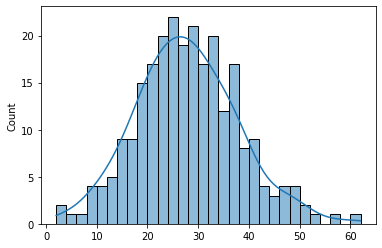

In [49]:
ax = sns.histplot(curry_points, kde=True, bins=30)

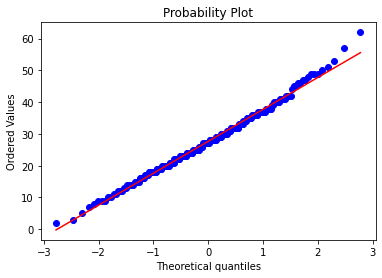

In [65]:
stats.probplot(curry_points, dist="norm", plot=plt)
plt.show()

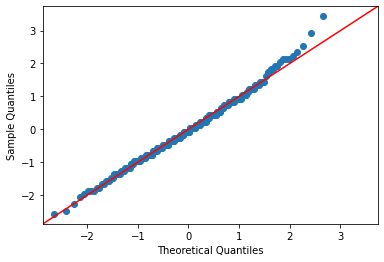

In [68]:
sm.qqplot(curry_points, line = "45", fit = True)
plt.show()

In [69]:
# ToDo - add explanation as to why qq-plots are a good indicator of gaussian distributions.
# https://www.graphpad.com/support/faq/testing-data-for-normal-distrbution/
# https://towardsdatascience.com/6-ways-to-test-for-a-normal-distribution-which-one-to-use-9dcf47d8fa93
# https://statsandr.com/blog/do-my-data-follow-a-normal-distribution-a-note-on-the-most-widely-used-distribution-and-how-to-test-for-normality-in-r/#how-to-test-the-normality-assumption


In [70]:
# Same analysis for morris and bonga

In [104]:
def plot_dists(filepath):
    points_df = pd.read_csv(filepath)
    points = points_df['Points'].values
    
    ax = sns.histplot(points, kde=True, bins=30)
    plt.show()
    
    _, bins, _ = plt.hist(points, 20, density=1, alpha=0.5)
    mu, sigma = norm.fit(points)
    best_fit_line = norm.pdf(bins, mu, sigma)
    plt.plot(bins, best_fit_line)
    print ('my',mu,'sigma',sigma)
    plt.show()
    
    stats.probplot(curry_points, dist="norm", plot=plt)
    plt.show()
    
    sm.qqplot(curry_points, line = "45", fit = True)
    plt.show()    

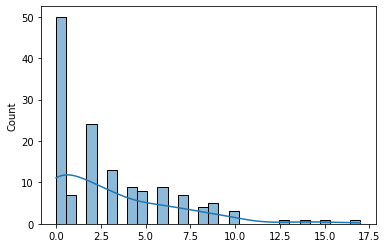

my 3.06993006993007 sigma 3.4714627812009784


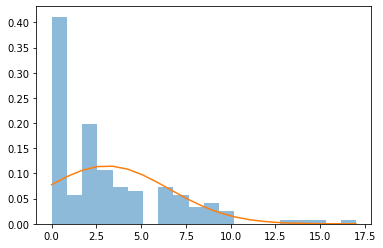

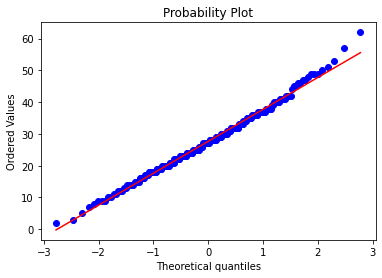

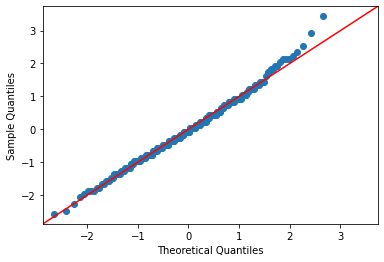

In [105]:
plot_dists('bonga_reg_season_scoring.csv')

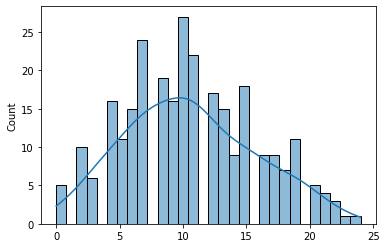

my 10.525 sigma 5.161611390143309


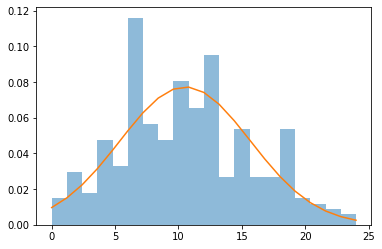

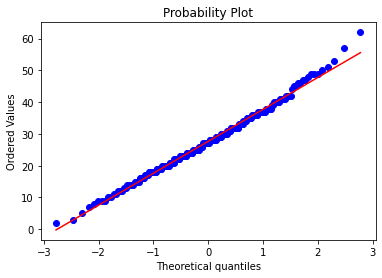

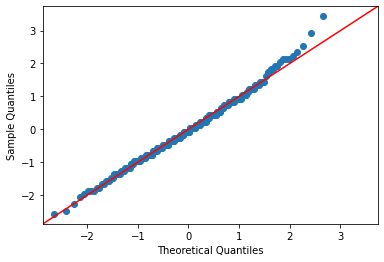

In [106]:
plot_dists('morris_reg_season_scoring.csv')

my 27.682539682539684 sigma 9.987016010205842


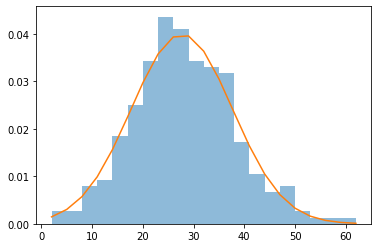

In [103]:
_, bins, _ = plt.hist(curry_points, 20, density=1, alpha=0.5)
mu, sigma = norm.fit(curry_points)
best_fit_line = norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)
print ('my',mu,'sigma',sigma)
plt.show()

Since for all 3 players, the scoring output can be approximated by a Gaussian distribution, we proceed as follows to determine the point totals for all players during game simulation:
1. Fit a Gaussian distribution to